In [106]:
import datetime
import backtrader as bt
import backtrader.indicators as btind
import pandas as pd
from pandas import Series, DataFrame
import random
from copy import deepcopy
import sys
import pandas as pd
sys.path.append('../lib/')
from dbConnect import *

class SMAC(bt.Strategy):
    """A simple moving average crossover strategy; crossing of a fast and slow moving average generates buy/sell
       signals"""
    params = {"fast": 20, "slow": 50,                  # The windows for both fast and slow moving averages
              "optim": False, "optim_fs": (20, 50)}    # Used for optimization; equivalent of fast and slow, but a tuple
                                                       # The first number in the tuple is the fast MA's window, the
                                                         # second the slow MA's window
    def __init__(self):

        self.fastma = dict()
        self.slowma = dict()
        self.regime = dict()

        self._addobserver(True, bt.observers.BuySell)    # CAUTION: Abuse of the method, I will change this in future code (see: https://community.backtrader.com/topic/473/plotting-just-the-account-s-value/4)

        if self.params.optim:    # Use a tuple during optimization
            self.params.fast, self.params.slow = self.params.optim_fs    # fast and slow replaced by tuple's contents

        if self.params.fast > self.params.slow:
            raise ValueError(
                "A SMAC strategy cannot have the fast moving average's window be " + \
                 "greater than the slow moving average window.")

        for d in self.getdatanames():

            # The moving averages
            self.fastma[d] = btind.SimpleMovingAverage(self.getdatabyname(d),      # The symbol for the moving average
                                                       period=self.params.fast,    # Fast moving average
                                                       plotname="FastMA: " + d)
            self.slowma[d] = btind.SimpleMovingAverage(self.getdatabyname(d),      # The symbol for the moving average
                                                       period=self.params.slow,    # Slow moving average
                                                       plotname="SlowMA: " + d)

            # Get the regime
            self.regime[d] = self.fastma[d] - self.slowma[d]    # Positive when bullish

    def next(self):
        """Define what will be done in a single step, including creating and closing trades"""
        for d in self.getdatanames():    # Looping through all symbols
            pos = self.getpositionbyname(d).size or 0
            if pos == 0:    # Are we out of the market?
                # Consider the possibility of entrance
                # Notice the indexing; [0] always mens the present bar, and [-1] the bar immediately preceding
                # Thus, the condition below translates to: "If today the regime is bullish (greater than
                # 0) and yesterday the regime was not bullish"
                if self.regime[d][0] > 0 and self.regime[d][-1] <= 0:    # A buy signal
                    self.buy(data=self.getdatabyname(d))

            else:    # We have an open position
                if self.regime[d][0] <= 0 and self.regime[d][-1] > 0:    # A sell signal
                    self.sell(data=self.getdatabyname(d))

class PropSizer(bt.Sizer):
    """A position sizer that will buy as many stocks as necessary for a certain proportion of the portfolio
       to be committed to the position, while allowing stocks to be bought in batches (say, 100)"""
    params = {"prop": 0.1, "batch": 10}

    def _getsizing(self, comminfo, cash, data, isbuy):
        """Returns the proper sizing"""

        if isbuy:    # Buying
            target = self.broker.getvalue() * self.params.prop    # Ideal total value of the position
            price = data.close[0]
            shares_ideal = target / price    # How many shares are needed to get target
            batches = int(shares_ideal / self.params.batch)    # How many batches is this trade?
            shares = batches * self.params.batch    # The actual number of shares bought

            if shares * price > cash:
                return 0    # Not enough money for this trade
            else:
                return shares

        else:    # Selling
            return self.broker.getposition(data).size    # Clear the position

class AcctValue(bt.Observer):
    alias = ('Value',)
    lines = ('value',)

    plotinfo = {"plot": True, "subplot": True}

    def next(self):
        self.lines.value[0] = self._owner.broker.getvalue()    # Get today's account value (cash + stocks)

In [107]:
cerebro = bt.Cerebro()    
cerebro.broker.set_cash(1000000)    
cerebro.broker.setcommission(0.02)

cerebro.addobserver(AcctValue)
cerebro.addstrategy(SMAC)
cerebro.addsizer(PropSizer)

In [108]:
cerebro.broker.getvalue()

1000000

In [109]:
fromdate = datetime.datetime(2010,1,1)
todate   = datetime.datetime(2017,1,1)
is_first = True
# Not the same set of symbols as in other blog posts
symbols = ['000050']
plot_symbols = ["AAA"]
#plot_symbols = []
for code in symbols:
  
    db_frame = pd.read_sql("SELECT * from dailycandle where code = {} and date between '{}' \
                            and '{}'".format(code, fromdate, todate), con=engine, index_col=["date"])
    db_frame['openinterest'] = 0
    db_frame.drop(['code'], axis=1,inplace=True);
    data = bt.feeds.PandasData(dataname=db_frame)
    
    if s in plot_symbols:
        if is_first:
            data_main_plot = data
            is_first = False
        else:
            data.plotinfo.plotmaster = data_main_plot
    else:
        data.plotinfo.plot = False
    cerebro.adddata(data)    # Give the data to cerebro

In [110]:
db_frame.tail()

open   high    low  close  volume  openinterest
date                                                        
2016-12-23  15850  16000  15800  15900   24452             0
2016-12-26  15900  16100  15550  15650   44868             0
2016-12-27  15600  16300  15600  15900   66299             0
2016-12-28  15850  15950  15550  15550   44405             0
2016-12-29  15650  15700  15300  15300   34004             0

In [111]:
db_frame.head()

open   high   low  close  volume  openinterest
date                                                      
2010-01-04  9880  10184  9766   9918    9486             0
2010-01-05  9956  10032  9500   9956   19578             0
2010-01-06  9956  10222  9804  10222    6776             0
2010-01-07  9994  10260  9994  10184   11302             0
2010-01-08  9994  10412  9994  10032    7605             0

In [112]:
cerebro.broker.getvalue()

1000000

In [113]:
%time cerebro.run()

Wall time: 4.38 s


In [114]:
cerebro.broker.getvalue()

991260.2000000001

<IPython.core.display.Javascript object>


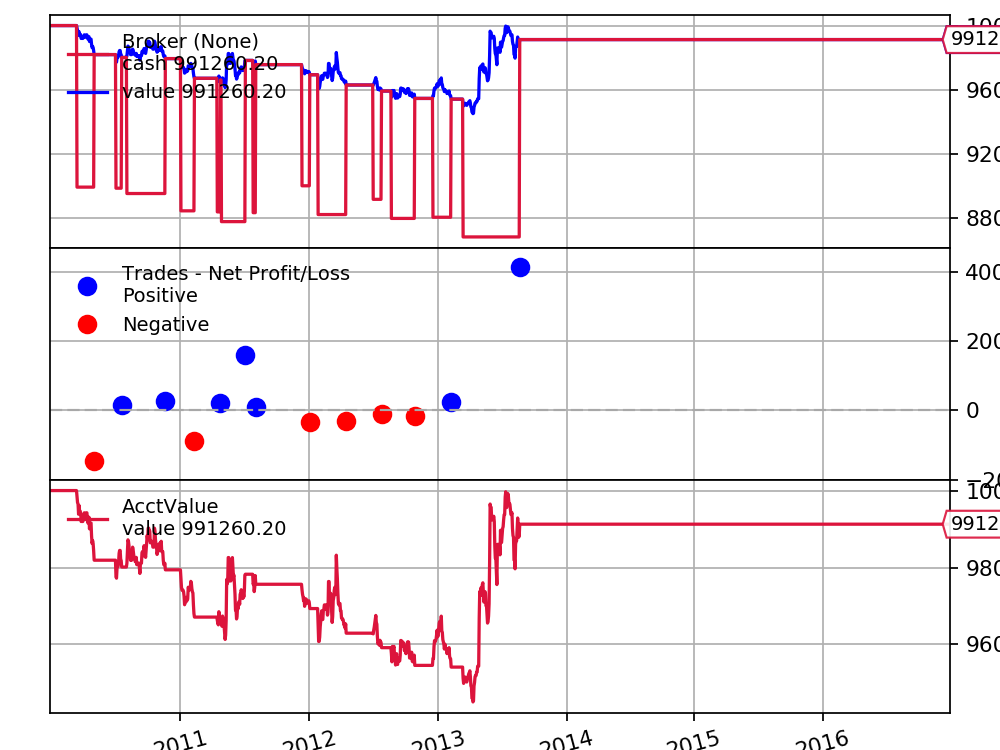

[[<matplotlib.figure.Figure at 0xb038870>]]

In [115]:
cerebro.plot()